# Bayesian optimization

In [1]:
import gpie
print(gpie.__version__)

0.2.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from gpie.base import Bounds
from gpie.kernel import MaternKernel, WhiteKernel,\
    GaussianProcessRegressor, BayesianOptimizer

In [4]:
# fix random seed
np.random.seed(len('BayesOpt'))

In [5]:
# test function (smooth, bimodal)
vf = lambda x: x**2 - 0.7 * x + np.sin(3. * x) - 0.5 # vector input
f = lambda x: vf(x.item()) # scalar input

# make grid data
X = np.linspace(-1., 2., 51)
Y = vf(X)

In [6]:
# extract optimization trajectory
X_ = X.reshape((-1, 1))
trajectory = list()

# inspect internal states of bayesian optimizer
def callback(bayesopt):
    acquisition = bayesopt.surrogate._acq(bayesopt.acquisition)
    acquisitions = np.array([acquisition(x) for x in X_])
    trajectory.append({'f posterior': bayesopt.surrogate.posterior_predictive(X_), 
                       'acquisition': acquisitions, 
                       'xs': bayesopt.X, 'fs': bayesopt.y})

In [7]:
# main routine of bayesian optimization
# bounds
x_lo, x_hi = -1., 2.
b = Bounds(np.array([x_lo]), np.array([x_hi]))
# initial query
x0 = np.random.uniform(x_lo, x_hi, (1, 1))
# number of evaluations
n_evals = 10
# surrogate model (Gaussian process)
surrogate = GaussianProcessRegressor(1.0 * MaternKernel(d=5, l=1.0) +
                                     1.0 * WhiteKernel())
# bayesian optimizer
bayesopt = BayesianOptimizer(fun=f, bounds=b, x0=x0, n_evals=n_evals, 
                             acquisition='lcb', surrogate=surrogate)
bayesopt.minimize(callback=callback)

C:\Apps\Miniconda3\envs\test\lib\site-packages\gpie\kernel\bayes_optimizer.py:143: UserWarning: turn to pure exploration.
  warnings.warn('turn to pure exploration.')


{'f': -0.9984083131237724, 'x': array([-0.37913812])}

In [8]:
# visualization settings
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 3 * n_evals]
plt.rcParams['figure.dpi'] = 200

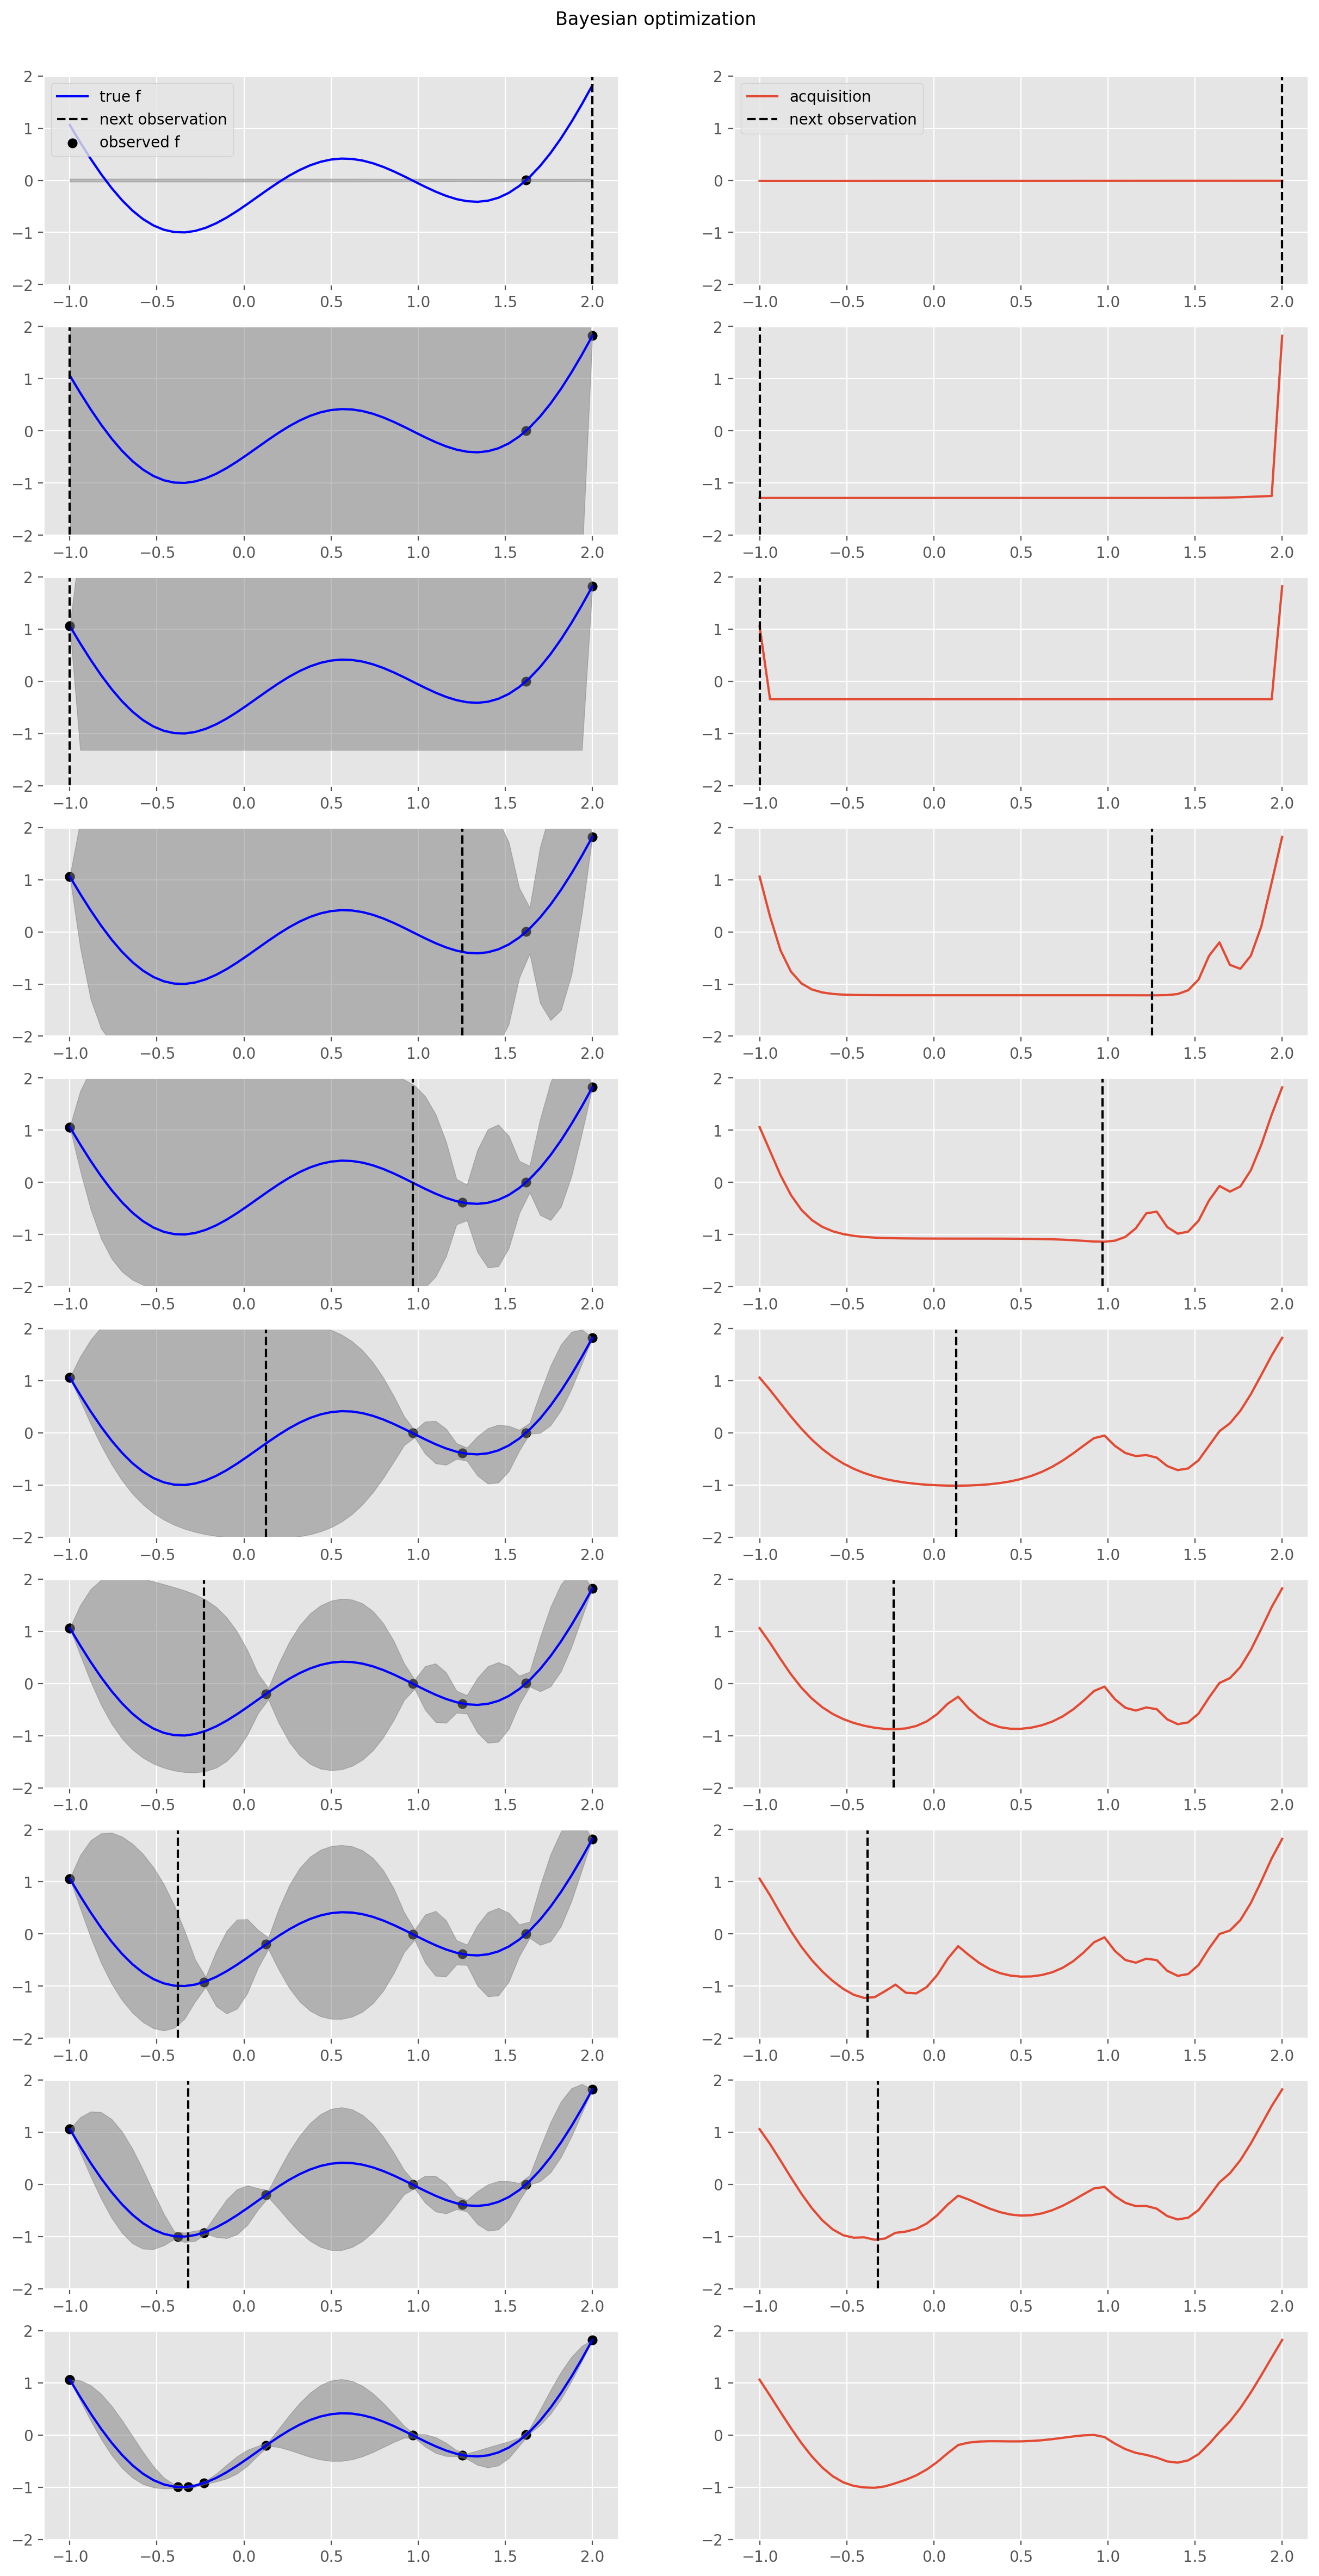

In [9]:
# visualization
fig, axes = plt.subplots(nrows=n_evals, ncols=2)
plt.suptitle('Bayesian optimization', y=0.9)
for i in range(n_evals):
    
    # test function
    axes[i][0].plot(X, Y, color='blue', label='true f')
    
    axes[i][0].scatter(trajectory[i]['xs'].flatten(),
                       trajectory[i]['fs'], 
                       marker='o', color='black',
                       label='observed f')
    
    
    # posterior predictive
    f_posterior = trajectory[i]['f posterior']
    f_mu_pred = f_posterior.mu
    f_sd_pred = np.sqrt(np.diag(f_posterior.cov))
    axes[i][0].fill_between(X, f_mu_pred - 1.96 * f_sd_pred,
                               f_mu_pred + 1.96 * f_sd_pred,
                            alpha=0.5, color='tab:gray')
    
    # acquisition surface
    acquisitions = trajectory[i]['acquisition']
    axes[i][1].plot(X, acquisitions, label='acquisition')
    if i < n_evals - 1:
        for j in range(2):
            axes[i][j].axvline(trajectory[i+1]['xs'].flatten()[-1],
                               linestyle='--', color='black', 
                               label='next observation')
            
    # formatting
    axes[i][0].set_ylim(-2, 2)
    axes[i][1].set_ylim(-2, 2)
    axes[0][0].legend(loc=2)
    axes[0][1].legend(loc=2)